# Text to Image pipeline and OpenVINO with Generate API

OpenVINO GenAI is a new flavor of OpenVINO, aiming to simplify running inference of generative AI models. It hides the complexity of the generation process and minimizes the amount of code required. You can now provide a model and input context directly to OpenVINO, which performs tokenization of the input text, executes the generation loop on the selected device, and returns the generated results. For a quick start guide, refer to the [GenAI API Guide](https://docs.openvino.ai/2024/learn-openvino/llm_inference_guide/genai-guide.html).

In this notebook we will demonstrate how to use text to image models like Stable Diffusion 1.5, 2.1, LCM using [Dreamlike Anime 1.0](https://huggingface.co/dreamlike-art/dreamlike-anime-1.0) as an example. All it takes is two steps: 
1. Export OpenVINO IR format model using the [Hugging Face Optimum](https://huggingface.co/docs/optimum/installation) library accelerated by OpenVINO integration.
The Hugging Face Optimum Intel API is a high-level API that enables us to convert and quantize models from the Hugging Face Transformers library to the OpenVINO™ IR format. For more details, refer to the [Hugging Face Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/inference).
2. Run inference using the standard [Text to Image pipeline](https://openvino-doc.iotg.sclab.intel.com/seba-test-4/learn-openvino/llm_inference_guide/genai-guide/genai-use-cases.html#using-genai-for-text-to-image-generation) from OpenVINO GenAI.



#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model using Optimum-CLI tool](#Convert-model-using-Optimum-CLI-tool)
- [Run inference OpenVINO model with Text2ImagePipeline](#Run-inference-OpenVINO-model-with-Text2ImagePipeline)
- [Run inference OpenVINO model with Text2ImagePipeline with optional LoRA adapters](#Run-inference-OpenVINO-model-with-Text2ImagePipeline-with-optional-LoRA-adapters)
- [Interactive demo](#Interactive-demo)

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/text-to-image-genai/text-to-image-genai.ipynb" />

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import requests


%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q --pre -U "openvino" "openvino-tokenizers" "openvino-genai" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly
%pip install -q Pillow "diffusers==0.30.3" "gradio>=4.19"

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

## Convert model using Optimum-CLI tool
[back to top ⬆️](#Table-of-contents:)

🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use cli interface for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

The command bellow demonstrates basic command for model export with `optimum-cli`

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <out_dir>
```

where `--model` argument is model id from HuggingFace Hub or local directory with model (saved using `.save_pretrained` method), `--task ` is one of [supported task](https://huggingface.co/docs/optimum/exporters/task_manager) that exported model should solve. For LLMs it will be `text-generation-with-past`. If model initialization requires to use remote code, `--trust-remote-code` flag additionally should be passed.
You can also apply fp16, 8-bit or 4-bit weight compression on the Linear, Convolutional and Embedding layers when exporting your model with the CLI by setting `--weight-format` to respectively fp16, int8 or int4. This type of optimization allows to reduce the memory footprint and inference latency.

In [2]:
from pathlib import Path


model_dir = Path("dreamlike_anime_1_0_ov/FP16")


if not model_dir.exists():
    !optimum-cli export openvino --model dreamlike-art/dreamlike-anime-1.0 --task stable-diffusion --weight-format fp16 {model_dir}

## Run inference OpenVINO model with Text2ImagePipeline
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [3]:
from notebook_utils import device_widget


device = device_widget("CPU")
device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

And now just provide `model_dir` and the chosen inference device to `openvino_genai.Text2ImagePipeline` and call `generate` method for inference. That's it:) 

In [4]:
import openvino_genai
from PIL import Image
import numpy as np


class Generator(openvino_genai.Generator):
    def __init__(self, seed, mu=0.0, sigma=1.0):
        openvino_genai.Generator.__init__(self)
        np.random.seed(seed)
        self.mu = mu
        self.sigma = sigma

    def next(self):
        return np.random.normal(self.mu, self.sigma)


def infer(model_dir, prompt):
    random_generator = Generator(42)  # openvino_genai.CppStdGenerator can be used to have same images as C++ sample
    pipe = openvino_genai.Text2ImagePipeline(model_dir, device.value)
    image_tensor = pipe.generate(prompt, width=512, height=512, num_inference_steps=20, num_images_per_prompt=1, random_generator=random_generator)

    image = Image.fromarray(image_tensor.data[0])

    return image

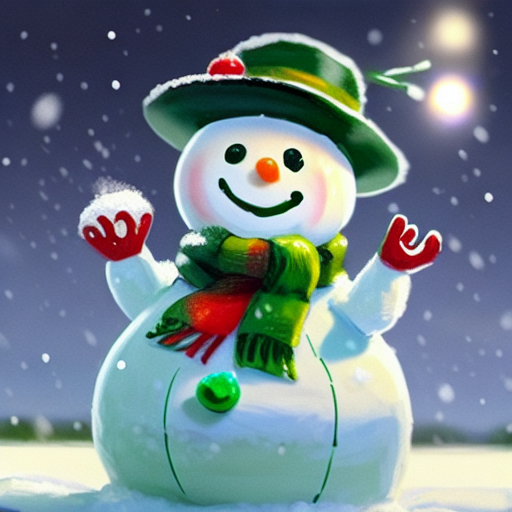

In [5]:
infer(model_dir, "anime, masterpiece, high quality, a green snowman with a happy smiling face in the snows")

## Run inference OpenVINO model with Text2ImagePipeline with optional LoRA adapters
[back to top ⬆️](#Table-of-contents:)

LoRA adapters can be connected to the pipeline and modify generated images to have certain style, details or quality. Adapters are supported in `Safetensors` format and can be downloaded from public sources like [Civitai](https://civitai.com) or [HuggingFace](https://huggingface.co/models) or trained by the user. Adapters compatible with a base model should be used only. A weighted blend of multiple adapters can be applied by specifying multiple adapter files with corresponding alpha parameters in command line. Check `lora.cpp` source code to learn how to enable adapters and specify them in each `generate` call.

Here is an example how to run the sample with a single adapter. First download adapter file from https://civitai.com/models/67927/soulcard page manually and save it as `soulcard.safetensors`. Or download it from command line:

In [6]:
r = requests.get(
    url="https://civitai.com/api/download/models/72591",
)
with open("soulcard.safetensors", "wb") as file:
    file.write(r.content)

In [7]:
def prepare_adapter_config(adapters):
    adapter_config = openvino_genai.AdapterConfig()

    # Multiple LoRA adapters applied simultaneously are supported, parse them all and corresponding alphas from cmd parameters:
    for i in range(int(len(adapters) / 2)):
        adapter = openvino_genai.Adapter(adapters[2 * i])
        alpha = float(adapters[2 * i + 1])
        adapter_config.add(adapter, alpha)

    return adapter_config


def infer_lora(model_dir, prompt, adapters):
    adapter_config = prepare_adapter_config(adapters)

    # LoRA adapters passed to the constructor will be activated by default in next generates
    pipe = openvino_genai.Text2ImagePipeline(model_dir, device.value, adapters=adapter_config)
    image_tensor = pipe.generate(prompt, random_generator=Generator(42), width=512, height=512, num_inference_steps=20)
    image = Image.fromarray(image_tensor.data[0])

    return image

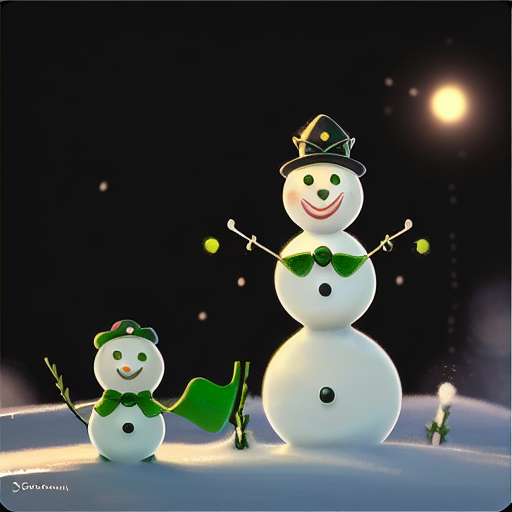

In [8]:
infer_lora(model_dir, "anime, masterpiece, high quality, a green snowman with a happy smiling face in the snows", ["soulcard.safetensors", 0.5])

## Interactive demo
[back to top ⬆️](#Table-of-contents:)
Check a pipeline for the interactive demo

In [9]:
import ipywidgets as widgets

use_lora = widgets.Checkbox(
    value=False,
    description="Use LoRA adapters",
)

use_lora

Checkbox(value=False, description='Use LoRA adapters')

In [ ]:
from gradio_helper import make_demo

if use_lora.value:
    adapter_config = prepare_adapter_config(["soulcard.safetensors", 0.5])
    pipe = openvino_genai.Text2ImagePipeline(model_dir, device.value, adapters=adapter_config)
else:
    pipe = openvino_genai.Text2ImagePipeline(model_dir, device.value)


demo = make_demo(pipe, Generator)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/